<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from IPython.display import Image
import sys
import pandas as pd
import HTM_Code as hc
import colorsys
import time as timer

In the last notebook we built a first Spatial Pooler. In this one, we will create a third version. We will hold off on building something more vectorised, but put standard features that are mentioned in episodes 7 and 8 of HTM School

In [2]:
ep7 = '<iframe style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/R5UoFNtv5AU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
ep8 = '<iframe  style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/rHvjykCIrZM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
table = '<table style="width:100%"><tr><td>' + ep7 + '</td><td>' + ep8 + '</td></tr>'
HTML(table)

,


Its also time now to finally use some real data. Its a data set of 4391 records, that tracks power consuptiom in a gymnasium over time. Let's import the data and have a look at it: 

In [3]:
df = pd.read_csv("./data/gymdata.csv", header=1)
df = df.rename(columns={"datetime": "date_time", "float": "power_consumption"})
df = df.iloc[1:]
df.head()

,date_time,power_consumption
1,7/2/10 0:00,21.2
2,7/2/10 1:00,16.4
3,7/2/10 2:00,4.7
4,7/2/10 3:00,4.7
5,7/2/10 4:00,4.6


Let's plot the first 1000 records to get a sense of how things look:

<AxesSubplot:>

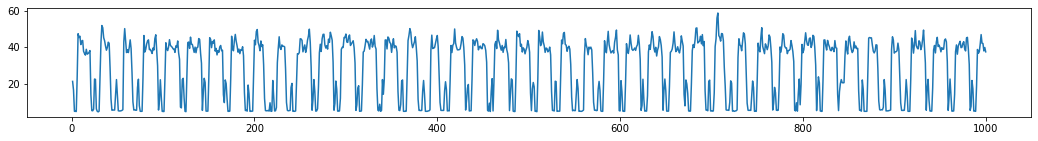

In [4]:
df.power_consumption[:1000].plot(figsize = (18,2))

Next, let's do bit of work on the data set, just to clean up the columns, to seperate date and time, and create an indicator of whether its weekend or not, so the data can easily be placed in a multi-encoder

In [5]:
df.date_time = pd.to_datetime(df.date_time, format="%m/%d/%y %H:%M")
df['date'] = [d.date() for d in df.date_time]
df['time_of_day'] = [d.time() for d in df.date_time]
df['weekday'] = [d.weekday() for d in df.date]
df['is_weekend'] = df.loc[df.weekday < 4, 'weekday'] = 0
df['is_weekend'] = df.loc[df.weekday >= 4, 'weekday'] = 1
df = df.drop('date_time', axis=1)
df = df.drop('weekday', axis=1)

df.head()

,power_consumption,date,time_of_day,is_weekend
1,21.2,2010-07-02,00:00:00,1
2,16.4,2010-07-02,01:00:00,1
3,4.7,2010-07-02,02:00:00,1
4,4.7,2010-07-02,03:00:00,1
5,4.6,2010-07-02,04:00:00,1


The other thing we will bring in at this point start referencing at this point is a glossary. From episode 7 there is alot of nomencalture with all the HTM stuff, and we need a way to organise it careful with the nomenclature. I want to have it as a handy reference so have just created a spreadhseet, and will now so let's bring that in too and sort it by spatial pooler tag, subtle differences across different things so we need to be start beign really careful with the way we are using language. 

We will also start working more closely with Nupic Code Base at this point

In [6]:
glossary = pd.read_csv("./data/glossary.csv", header=0)
glossary.loc[glossary['Tags'].str.contains("spatial pooler")].style.set_properties(**{'text-align': 'left'})

,Tags,Term,ParamName,Description
0,spatial pooler,Column,column,"An HTM region is organized in columns of cells. The SP operates at the column-level, where a column of a cells function as a single computational unit."
1,spatial pooler,Inhibition,nan,The mechanism for maintaining sparse activations of neurons. In the SP this manifests as columns inhibiting nearby columns from becoming active.
2,spatial pooler,Inhibition radius,nan,"The size of a column's local neighborhood, within which columns may inhibit each other from becoming active."
3,spatial pooler,Active duty cycle,activeDutyCycle,A moving average denoting the frequency of column activation.
4,spatial pooler,Overlap duty cycle,overlapDutyCycle,A moving average denoting the frequency of the column's overlap value being at least equal to the proximal segment activation threshold.
5,spatial pooler,Receptive field,receptiveReceptiveField,The input space that a column can potentially connect to
6,spatial pooler,Permance value,permancePermanceValue,"indicates the amount of growth between a mini-column in the Spatial Pooling algorithm and one of the cells in its receptive field. Acceptable values are [0,1]."
7,spatial pooler,Permance threshold,permancePermanceThreshold,"If a synapse's permanence is above this value, it is considered fully connected."
8,spatial pooler; neuroscience,Synapse,nan,"A junction between cells. In the Spatial Pooling algorithm, synapses on a column's dendritic segment connect to bits in the input space. A synapse can be in the following states: Connected: permanence is above the threshold, Potential: permanence is below the threshold, Unconnected: does not have the ability to connect."


With that out of the way, let's create an instance of a MultiEncoder and put our data into it. We will need four encoders, one for power consumption, one for date, one for time of day, and one for weekend:

Now let's put all those into a single encoder, the inputs ready for our spatial pooler. 

Now let's create new version of our Spatial Pooler. It will do much of the previous version, but a number of extra features, that get discussed in episode 8. We will also model our Spatial Pooler more along the lines of <a href="#">https://github.com/numenta/nupic/blob/master/src/nupic/algorithms/spatial_pooler.py</a>. We will use similiar variable names, but we will keep the methods a bit simpler to emphasise the various steps in what is happening. The steps will be pretty linear and our code will do the following:

1. <code>intialiseColumnsToInputSpace()</code>
2. <code>addInputsToSpatialPooler()</code>
3. <code>computeOverlapOfInputAndActiveColumn()</code>
4. <code>updateColumnPotentialConnectionsAndReinitialiseColumnToInputSpace()</code>

We will also create a <code>getSummary()</code> function to keep track of things, and <code> create_comparison_from_each_bit_in_input_space_to_its_active_columns()</code> to provide some data so we can look at any given input space and how it is connected:
        

In [7]:
class SpatialPoolerV3:
    def __init__(self,
               inputDimensions=[32, 32],
               columnDimensions=[64, 64],
               potentialRadius=16,
               potentialPct=0.5,
               globalInhibition=True,
               numActiveColumnsPerInhArea=10.0,
               stimulusThreshold=0,
               synPermInactiveDec=0.008,
               synPermActiveInc=0.05,
               synPermConnected=0.10):
        
        self._numInputs = np.prod(inputDimensions)
        self._numColumns = np.prod(columnDimensions)
        self._columnDimensions = columnDimensions
        self._inputDimensions = inputDimensions
        self._potentialRadius = int(max(potentialRadius, self._numInputs))
        self._potentialPct = potentialPct
        self._globalInhibition = globalInhibition 
        self._numActiveColumnsPerInhArea = int(numActiveColumnsPerInhArea)
        self._stimulusThreshold = stimulusThreshold
        self._synPermInactiveDec = synPermInactiveDec
        self._synPermActiveInc = synPermActiveInc
        self._synPermConnected = synPermConnected
        self._columns = {}
        self._columnsInitialised = False
    

    def initialise_columns_to_input_space(self):
        timerStart = timer.perf_counter()
        potentialPoolSize = int(self._potentialPct * self._numInputs)

        for i in range(self._numColumns):
        
            potentialConnections = hc.create_randomised_sdr(self._numInputs, potentialPoolSize)
            nonConnectedColumns = [x for x in range(0, self._numInputs) if x not in potentialConnections]
            potentialConnectionsPermanenceValues = np.random.normal(self._synPermConnected, 0.01, potentialPoolSize)
            activeColumns = []
            
            for j in range(0, len(potentialConnections)):
                if potentialConnectionsPermanenceValues[j] > 0.1:
                    activeColumns.append(potentialConnections[j])
                    
            self._columns[i] = {'potentialConnections': potentialConnections,
                                'nonConnectedColumns': nonConnectedColumns,
                                'potentialConnectionsPermanenceValues': potentialConnectionsPermanenceValues,
                                'activeColumns': activeColumns
                              }
        self._columnsInitialised = True
        timerEnd = timer.perf_counter()
        self.getSummary(summary_type = 2, timeTaken = timerEnd - timerStart)
    

    
    def add_inputs_to_spatial_pooler(self):
        pass
    
    def compute_overlap_of_input_and_active_column(self):
        pass
    
    def update_column_potential_connections_and_reinitialise_column_to_input_space(self):
        pass
    
    def create_comparison_from_each_bit_in_input_space_to_its_active_columns(self):
        pass
    
    def getSummary(self, summary_type, timeTaken = 0):
        print("\n----------------- SUMMARY -------------------------")
        if summary_type == 1:
            print("|L1| Column space size (numColumns):", self._numColumns)
            print("|L2| Input space size (numInputs):", self._numInputs)
            print("|L3| Input bits visible to each columns, or receptive field (potentialRadius):", self._potentialRadius)
            print("|L4| The percent of the inputs, within a column's potential radius, that a column can be connected to (potentialPct):", self._potentialPct * 100, "%")
            print("|L5| Global Inhibition is on, so winning columns are selected as the most active columns from the whole region (globalInhibition):", self._globalInhibition)
            print("|L6| Density of active columns within inhibition area (numActiveColumnsPerInhArea):", self._numActiveColumnsPerInhArea)
            print("|L7| Minimum number of synapses that must be on in order for a columns to turn ON (stimulusThreshold):", self._stimulusThreshold)
            print("|L8| Amount by which an inactive synapse is decremented in each time step (synPermInactiveDec):", self._synPermInactiveDec)
            print("|L9| Amount by which an active synapse is incremented in each time step (synPermActiveInc):", self._synPermActiveInc)
            print("|L10| Any synapse whose permanence value is above this value is a connected synapse (synPermConnected):", self._synPermConnected)
            print("|L11| Columns initialised:", self._columnsInitialised)
        elif summary_type == 2:
            print("|L1| Based on initital paramaters, each of the", self._numColumns, "columns in this Spatial Pooler has a potential connection to", self._potentialPct, "of bits in the input space")
            print("|L1| The values of all potential connection strength are normally distributed between approximately", np.round(min(self._columns[0]['potentialConnectionsPermanenceValues']), 3),
              "and", np.round(max(self._columns[0]['potentialConnectionsPermanenceValues']),3))
            print("|L1| Based on the connection threshold set at", self._synPermConnected,",", len(self._columns[0]['activeColumns']), "columns will now be active in the Spatial Pooler")
            print("|L1| Time elapsed during initialisation:", np.round(timeTaken,4), "seconds.")

        
        

In [8]:
s1 = SpatialPoolerV3()
s1.getSummary(1)
s1.initialise_columns_to_input_space()


----------------- SUMMARY -------------------------
|L1| Column space size (numColumns): 4096
|L2| Input space size (numInputs): 1024
|L3| Input bits visible to each columns, or receptive field (potentialRadius): 1024
|L4| The percent of the inputs, within a column's potential radius, that a column can be connected to (potentialPct): 50.0 %
|L5| Global Inhibition is on, so winning columns are selected as the most active columns from the whole region (globalInhibition): True
|L6| Density of active columns within inhibition area (numActiveColumnsPerInhArea): 10
|L7| Minimum number of synapses that must be on in order for a columns to turn ON (stimulusThreshold): 0
|L8| Amount by which an inactive synapse is decremented in each time step (synPermInactiveDec): 0.008
|L9| Amount by which an active synapse is incremented in each time step (synPermActiveInc): 0.05
|L10| Any synapse whose permanence value is above this value is a connected synapse (synPermConnected): 0.1
|L11| Columns initial

Now its time to add some inputs

